# JavaScript 异步编程
## 异步的概念
异步（Asynchronous, async）是与同步（Synchronous, sync）相对的概念。

在我们学习的传统单线程编程中，程序的运行是同步的（同步不意味着所有步骤同时运行，而是指步骤在一个控制流序列中按顺序执行）。而异步的概念则是不保证同步的概念，也就是说，一个异步过程的执行将不再与原有的序列有顺序关系。

简单来理解就是：同步按你的代码顺序执行，异步不按照代码顺序执行，异步的执行效果更高：

以上是关于异步的概念的解释，接下来我们通俗地解释一下异步：异步就是从主线程发射一个子线程来完成任务。
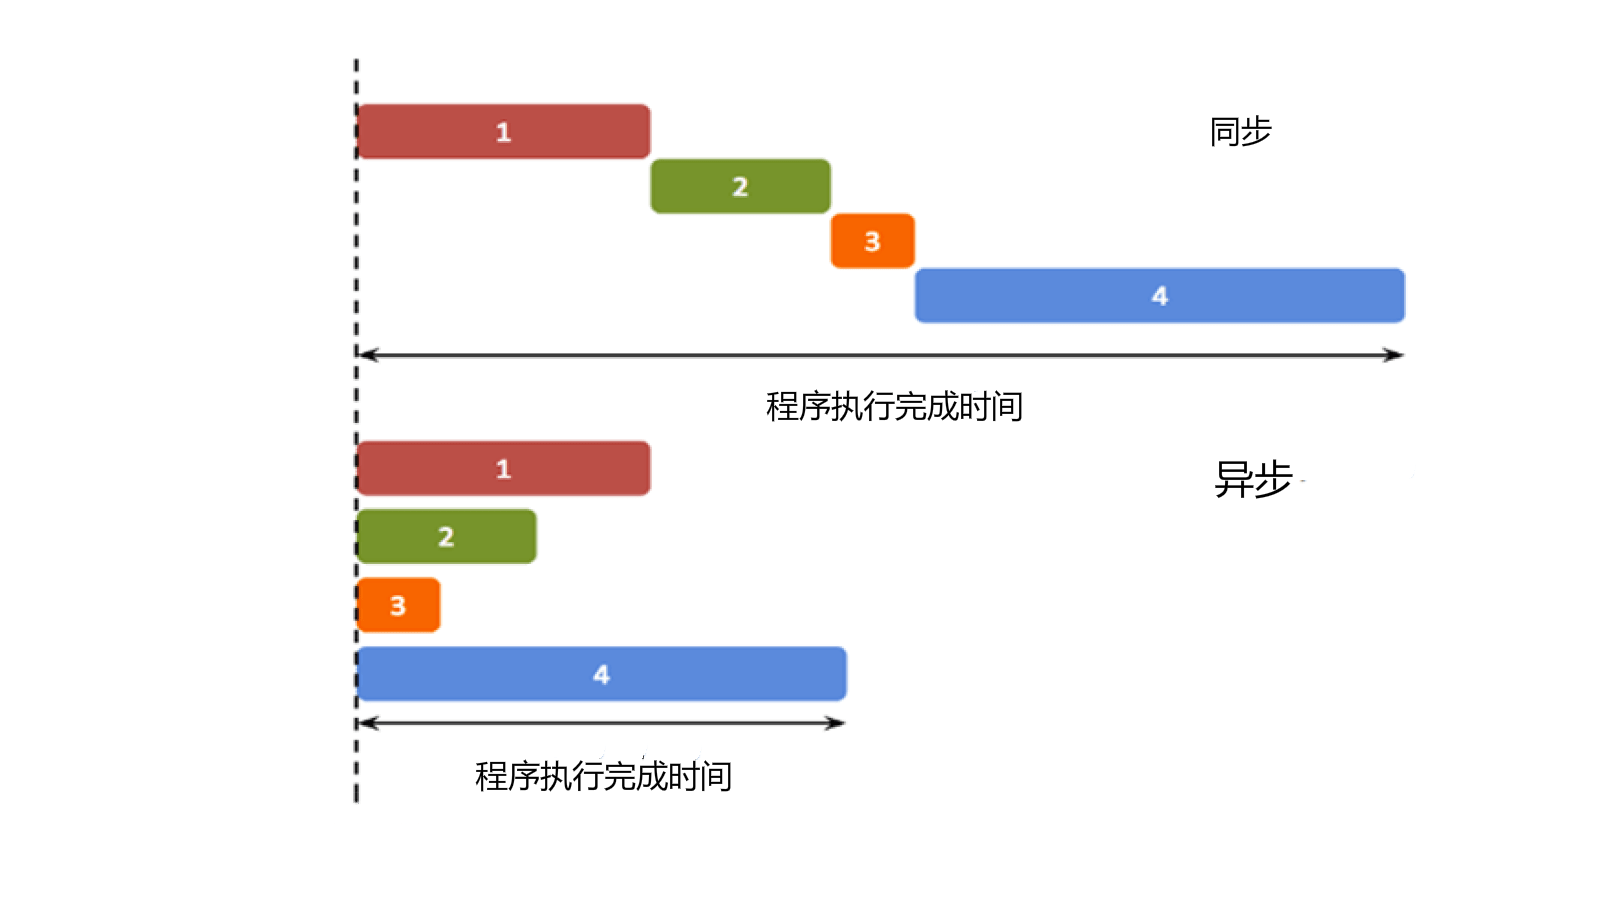

## 什么时候用异步编程
在前端编程中（甚至后端有时也是这样），我们在处理一些简短、快速的操作时，例如计算 1 + 1 的结果，往往在主线程中就可以完成。主线程作为一个线程，不能够同时接受多方面的请求。所以，当一个事件没有结束时，界面将无法处理其他请求。

现在有一个按钮，如果我们设置它的 onclick 事件为一个死循环，那么当这个按钮按下，整个网页将失去响应。

为了避免这种情况的发生，我们常常用子线程来完成一些可能消耗时间足够长以至于被用户察觉的事情，比如读取一个大文件或者发出一个网络请求。因为子线程独立于主线程，所以即使出现阻塞也不会影响主线程的运行。但是子线程有一个局限：一旦发射了以后就会与主线程失去同步，我们无法确定它的结束，如果结束之后需要处理一些事情，比如处理来自服务器的信息，我们是无法将它合并到主线程中去的。

为了解决这个问题，JavaScript 中的异步操作函数往往通过回调函数来实现异步任务的结果处理。

## [JS 异步编程六种方案](https://www.jianshu.com/p/d7f6077a0dd2)

### 回调函数
回调函数就是一个函数，它是在我们启动一个异步任务的时候就告诉它：等你完成了这个任务之后要干什么。这样一来主线程几乎不用关心异步任务的状态了，他自己会善始善终。

回调函数是异步操作最基本的方法。以下代码就是一个回调函数的例子：
```js
ajax(url, () => {
    // 处理逻辑
})
```
但是回调函数有一个致命的弱点，就是容易写出回[**调地狱（Callback hell）{what & handle}**](https://www.cnblogs.com/kainanhong/p/6671340.html)。假设多个请求存在依赖性，你可能就会写出如下代码：
```js
ajax(url, () => {
    // 处理逻辑
    ajax(url1, () => {
        // 处理逻辑
        ajax(url2, () => {
            // 处理逻辑
        })
    })
})
```
回调函数的优点是简单、容易理解和实现，缺点是不利于代码的阅读和维护，各个部分之间高度耦合，使得程序结构混乱、流程难以追踪（尤其是多个回调函数嵌套的情况），而且每个任务只能指定一个回调函数。此外它不能使用 try catch 捕获错误，不能直接 return。

In [19]:
// setTimeout 会在子线程中等待 x 秒，在 setTimeout 函数执行之后主线程并没有停止
for (let i = 0; i < 10; i++){
    setTimeout(function () {
        console.log("1");
    }, i);
    console.log("2");
    setTimeout(function () {
        console.log("3");
    }, i+4);
}

2
2
2
2
2
2
2
2
2
2


Timeout {
  _idleTimeout: 13,
  _idlePrev: [TimersList],
  _idleNext: [TimersList],
  _idleStart: 682082,
  _onTimeout: [Function (anonymous)],
  _timerArgs: undefined,
  _repeat: null,
  _destroyed: false,
  [Symbol(refed)]: true,
  [Symbol(asyncId)]: 1274,
  [Symbol(triggerId)]: 1249
}

1
1
1
3
1
1
3
1
3
1
3
1
3
1
3
1
3
3
3
3


### 事件监听
这种方式下，**异步任务的执行不取决于代码的顺序，而取决于某个事件是否发生。**

下面是两个函数f1和f2，编程的意图是f2必须等到f1执行完成，才能执行。首先，为f1绑定一个事件（这里采用的jQuery的写法）

```js
f1.on('done', f2);
```
上面这行代码的意思是，当f1发生done事件，就执行f2。然后，对f1进行改写：
```js
function f1() {
  setTimeout(function () {
    // ...
    f1.trigger('done');
  }, 1000);
}
```
上面代码中，f1.trigger('done')表示，执行完成后，立即触发done事件，从而开始执行f2。

这种方法的优点是比较容易理解，可以绑定多个事件，每个事件可以指定多个回调函数，而且可以"去耦合"，有利于实现模块化。缺点是整个程序都要变成事件驱动型，运行流程会变得很不清晰。阅读代码的时候，很难看出主流程。

### 发布订阅
我们假定，存在一个"信号中心"，某个任务执行完成，就向信号中心"发布"（publish）一个信号，其他任务可以向信号中心"订阅"（subscribe）这个信号，从而知道什么时候自己可以开始执行。这就叫做"发布/订阅模式"（publish-subscribe pattern），又称"观察者模式"（observer pattern）。

首先，f2向信号中心jQuery订阅done信号。

```js
jQuery.subscribe('done', f2);
```
然后，f1进行如下改写：
```js
function f1() {
  setTimeout(function () {
    // ...
    jQuery.publish('done');
  }, 1000);
}
```
上面代码中，jQuery.publish('done')的意思是，f1执行完成后，向信号中心jQuery发布done信号，从而引发f2的执行。
f2完成执行后，可以取消订阅（unsubscribe）
```js
jQuery.unsubscribe('done', f2);
```
这种方法的性质与“事件监听”类似，但是明显优于后者。因为可以通过查看“消息中心”，了解存在多少信号、每个信号有多少订阅者，从而监控程序的运行。

### Promise/A+
Promise本意是承诺，在程序中的意思就是承诺我过一段时间后会给你一个结果。 什么时候会用到过一段时间？答案是异步操作，异步是指可能比较长时间才有结果的才做，例如网络请求、读取本地文件等

#### Promise的三种状态
- Pending----Promise对象实例创建时候的初始状态
- Fulfilled----可以理解为成功的状态
- Rejected----可以理解为失败的状态
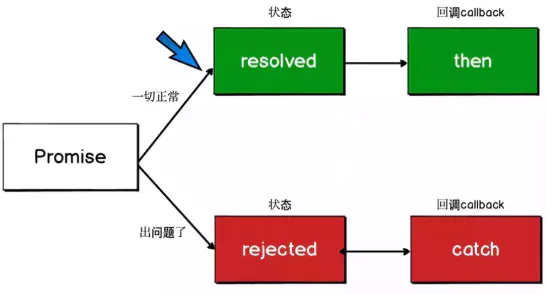

**这个承诺一旦从等待状态变成为其他状态就永远不能更改状态了**，比如说一旦状态变为 resolved 后，就不能再次改变为Fulfilled
```js
let p = new Promise((resolve, reject) => {
  reject('reject')
  resolve('success')//无效代码不会执行
})
p.then(
  value => {
    console.log(value)
  },
  reason => {
    console.log(reason)//reject
  }
)
```
当我们在构造 Promise 的时候，构造函数内部的代码是立即执行的
```js
new Promise((resolve, reject) => {
  console.log('new Promise')
  resolve('success')
})
console.log('end')
// new Promise => end
```

#### promise的链式调用
- 每次调用返回的都是一个新的Promise实例(这就是then可用链式调用的原因)
- 如果then中返回的是一个结果的话会把这个结果传递下一次then中的成功回调
- 如果then中出现异常,会走下一个then的失败回调
- 在 then中使用了return，那么 return 的值会被Promise.resolve() 包装(见例1，2)
- then中可以不传递参数，如果不传递会透到下一个then中(见例3)
- catch 会捕获到没有捕获的异常
接下来我们看几个例子：
```js
// 例1
Promise.resolve(1)
.then(res => {
    console.log(res)
    return 2 //包装成 Promise.resolve(2)
})
.catch(err => 3)
.then(res => console.log(res))
```

```js
// 例2
Promise.resolve(1)
    .then(x => x + 1)
    .then(x => {
        throw new Error('My Error')
    })
    .catch(() => 1)
    .then(x => x + 1)
    .then(x => console.log(x)) //2
    .catch(console.error)
```

```js
// 例3
let fs = require('fs')
function read(url) {
  return new Promise((resolve, reject) => {
    fs.readFile(url, 'utf8', (err, data) => {
      if (err) reject(err)
      resolve(data)
    })
  })
}
read('./name.txt')
    .then(function(data) {
        throw new Error() //then中出现异常,会走下一个then的失败回调
    }) //由于下一个then没有失败回调，就会继续往下找，如果都没有，就会被catch捕获到
    .then(function(data) {
        console.log('data')
    })
    .then()
    .then(null, function(err) {
        console.log('then', err)// then error
    })
    .catch(function(err) {
        console.log('error')
    })
```
Promise不仅能够捕获错误，而且也很好地解决了回调地狱的问题，可以把之前的回调地狱例子改写为如下代码：
```js
ajax(url)
  .then(res => {
      console.log(res)
      return ajax(url1)
  }).then(res => {
      console.log(res)
      return ajax(url2)
  }).then(res => console.log(res))
```
它也是存在一些缺点的，比如无法取消 Promise，错误需要通过回调函数捕获。

### 生成器Generators/ yield
Generator 函数是 ES6 提供的一种异步编程解决方案，语法行为与传统函数完全不同，Generator 最大的特点就是可以控制函数的执行。

- 语法上，首先可以把它理解成，Generator 函数是一个状态机，封装了多个内部状态。
- **Generator 函数除了状态机，还是一个遍历器对象生成函数。**
- **可暂停函数, yield可暂停，next方法可启动，每次返回的是yield后的表达式结果。**
- yield表达式本身没有返回值，或者说总是返回undefined。**next方法可以带一个参数，该参数就会被当作上一个yield表达式的返回值。**

我们先来看个例子：
```js
function *foo(x) {
  let y = 2 * (yield (x + 1))
  let z = yield (y / 3)
  return (x + y + z)
}
let it = foo(5)
console.log(it.next())   // => {value: 6, done: false}
console.log(it.next(12)) // => {value: 8, done: false}
console.log(it.next(13)) // => {value: 42, done: true}
```
可能结果跟你想象不一致，接下来我们逐行代码分析：
- 首先 Generator 函数调用和普通函数不同，它会返回一个迭代器
- 当执行第一次 next 时，传参会被忽略，并且函数暂停在 yield (x + 1) 处，所以返回 5 + 1 = 6
- 当执行第二次 next 时，传入的参数12就会被当作上一个yield表达式的返回值，如果你不传参，yield 永远返回 undefined。此时 let y = 2 * 12，所以第二个 yield 等于 2 * 12 / 3 = 8
- 当执行第三次 next 时，传入的参数13就会被当作上一个yield表达式的返回值，所以 z = 13, x = 5, y = 24，相加等于 42

我们再来看个例子：有三个本地文件，分别1.txt,2.txt和3.txt，内容都只有一句话，下一个请求依赖上一个请求的结果，想通过Generator函数依次调用三个文件
```js
//1.txt文件
2.txt

//2.txt文件
3.txt

//3.txt文件
结束
```

```js
let fs = require('fs')
function read(file) {
  return new Promise(function(resolve, reject) {
    fs.readFile(file, 'utf8', function(err, data) {
      if (err) reject(err)
      resolve(data)
    })
  })
}
function* r() {
  let r1 = yield read('./1.txt')
  let r2 = yield read(r1)
  let r3 = yield read(r2)
  console.log(r1)
  console.log(r2)
  console.log(r3)
}
let it = r()
let { value, done } = it.next()
value.then(function(data) { // value是个promise
  console.log(data) //data=>2.txt
  let { value, done } = it.next(data)
  value.then(function(data) {
    console.log(data) //data=>3.txt
    let { value, done } = it.next(data)
    value.then(function(data) {
      console.log(data) //data=>结束
    })
  })
})
// 2.txt=>3.txt=>结束
```

从上例中我们看出手动迭代 `Generator` 函数很麻烦，实现逻辑有点绕，而实际开发一般会配合` co `库去使用。`co`**是一个为Node.js和浏览器打造的基于生成器的流程控制工具，借助于Promise，你可以使用更加优雅的方式编写非阻塞代码。**

安装`co`库只需：`npm install co`

上面例子只需两句话就可以轻松实现
```js
function* r() {
  let r1 = yield read('./1.txt')
  let r2 = yield read(r1)
  let r3 = yield read(r2)
  console.log(r1)
  console.log(r2)
  console.log(r3)
}
let co = require('co')
co(r()).then(function(data) {
  console.log(data)
})
// 2.txt=>3.txt=>结束=>undefined
```
我们可以通过 Generator 函数解决回调地狱的问题，可以把之前的回调地狱例子改写为如下代码：
```js
function *fetch() {
    yield ajax(url, () => {})
    yield ajax(url1, () => {})
    yield ajax(url2, () => {})
}
let it = fetch()
let result1 = it.next()
let result2 = it.next()
let result3 = it.next()
```

### async/await
#### Async/Await简介
使用async/await，你可以轻松地达成之前使用生成器和co函数所做到的工作,它有如下特点：

- async/await是基于Promise实现的，它不能用于普通的回调函数。
- async/await与Promise一样，是非阻塞的。
- async/await使得异步代码看起来像同步代码，这正是它的魔力所在。

**一个函数如果加上 async ，那么该函数就会返回一个 Promise**
```js
async function async1() {
  return "1"
}
console.log(async1()) // -> Promise {<resolved>: "1"}
```
Generator函数依次调用三个文件那个例子用async/await写法，只需几句话便可实现
```js
let fs = require('fs')
function read(file) {
  return new Promise(function(resolve, reject) {
    fs.readFile(file, 'utf8', function(err, data) {
      if (err) reject(err)
      resolve(data)
    })
  })
}
async function readResult(params) {
  try {
    let p1 = await read(params, 'utf8')//await后面跟的是一个Promise实例
    let p2 = await read(p1, 'utf8')
    let p3 = await read(p2, 'utf8')
    console.log('p1', p1)
    console.log('p2', p2)
    console.log('p3', p3)
    return p3
  } catch (error) {
    console.log(error)
  }
}
readResult('1.txt').then( // async函数返回的也是个promise
  data => {
    console.log(data)
  },
  err => console.log(err)
)
// p1 2.txt
// p2 3.txt
// p3 结束
// 结束
```

#### Async/Await并发请求
如果请求两个文件，毫无关系，可以通过并发请求
```js
let fs = require('fs')
function read(file) {
  return new Promise(function(resolve, reject) {
    fs.readFile(file, 'utf8', function(err, data) {
      if (err) reject(err)
      resolve(data)
    })
  })
}
function readAll() {
  read1()
  read2()//这个函数同步执行
}
async function read1() {
  let r = await read('1.txt','utf8')
  console.log(r)
}
async function read2() {
  let r = await read('2.txt','utf8')
  console.log(r)
}
readAll() // 2.txt 3.txt
```

## 总结
1. **JS 异步编程进化史：callback -> promise -> generator -> async + await**
2. **async/await 函数的实现，就是将 Generator 函数和自动执行器，包装在一个函数里**
3. **async/await可以说是异步终极解决方案了**
    - **(1) async/await函数相对于Promise，优势体现在：**
        - 处理 then 的调用链，能够更清晰准确的写出代码
        - 并且也能优雅地解决回调地狱问题。
当然async/await函数也存在一些缺点，因为 await 将异步代码改造成了同步代码，如果多个异步代码没有依赖性却使用了 await 会导致性能上的降低，代码没有依赖性的话，完全可以使用 Promise.all 的方式。

    - **(2) async/await函数对 Generator 函数的改进，体现在以下三点：**
        - 内置执行器。
        - Generator 函数的执行必须靠执行器，所以才有了 co 函数库，而 async 函数自带执行器。也就是说，**async 函数的执行，与普通函数一模一样，只要一行。**
        - 更广的适用性。 co 函数库约定，yield 命令后面只能是 Thunk 函数或 Promise 对象，而 **async 函数的 await 命令后面，可以跟 Promise 对象和原始类型的值（数值、字符串和布尔值，但这时等同于同步操作）。**
        - 更好的语义。 async 和 await，比起星号和 yield，语义更清楚了。async 表示函数里有异步操作，await 表示紧跟在后面的表达式需要等待结果。